In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AirPassengers.csv")
df.columns = ["Month", "Passengers"]
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# General Information About to the Dataset

In [ ]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

######################### Head #########################
     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121
######################### Tail #########################
       Month  Passengers
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432
######################### Shape #########################
(144, 2)
######################### Types #########################
Month         object
Passengers     int64
dtype: object
######################### NA #########################
Month         0
Passengers    0
dtype: int64
######################### Qurtiles #########################
            count        mean         std    min     0%     5%    50%     95%     99%   100%    max
Passengers  144.0  280.298611  119.966317  104.0  104.0  121.6  265.5  488.15  585.79  622.0  622.0


# Data Preparation

In [ ]:
df["Month"] = pd.to_datetime(df["Month"])
df.index = df["Month"]
df.drop("Month", axis=1, inplace=True)
data = df["Passengers"].values
data = data.astype("float32")
data = data.reshape(-1,1)

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [ ]:
df.iloc[125:]

,Passengers
Month,
1959-06-01,472
1959-07-01,548
1959-08-01,559
1959-09-01,463
1959-10-01,407
1959-11-01,362
1959-12-01,405
1960-01-01,417
1960-02-01,391


In [ ]:
df.drop(df.index[125:], inplace=True)
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-01-01,360
1959-02-01,342
1959-03-01,406


In [ ]:
data[1:5]

array([[118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

In [ ]:
data.shape

(144, 1)

# Data Visualization

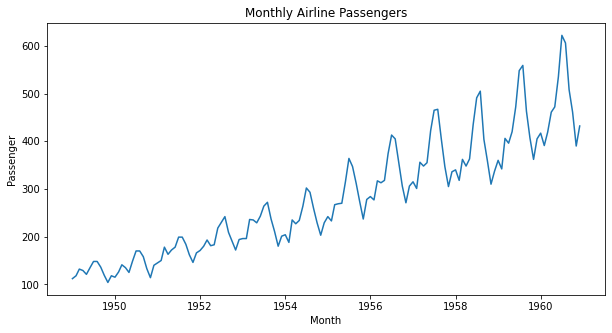

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df)
plt.title("Monthly Airline Passengers")
plt.xlabel("Month")
plt.ylabel("Passenger");

# Train and Test Split

In [ ]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [ ]:
train, test, position = split_data(df, 0.04)
print("Train shape:", train.shape, " Test shape:", test.shape)

Train shape: (120, 1)  Test shape: (5, 1)


In [ ]:
test

,Passengers
Month,
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396
1959-05-01,420


# Encoding Scaling

In [ ]:
def encoding_scaling(train, test):
  scaler_train = MinMaxScaler(feature_range=(0,1))
  train = scaler_train.fit_transform(train)
  scaler_test = MinMaxScaler(feature_range=(0,1))
  test = scaler_test.fit_transform(test)
  return scaler_train, train, scaler_test, test

In [ ]:
scaler_train, train, scaler_test, test  = encoding_scaling(train, test)

# Create Features

In [ ]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = create_features(train, 1)
X_test, y_test = create_features(test, 1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (119, 1)  y_train shape: (119,) 
X_test shape: (4, 1)  y_test shape:  (4,)


# RNN Data Format

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (119, 1, 1)  y_train shape: (119, 1) 
X_test shape: (4, 1, 1)  y_test shape:  (4, 1)


# Modeling

In [ ]:
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model1.compile(loss="mse", optimizer=optimizer)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test))

Epoch 1/20
4/4 [==============================] - 2s 94ms/step - loss: 0.7102 - val_loss: 1.3614
Epoch 2/20
4/4 [==============================] - 0s 15ms/step - loss: 0.6804 - val_loss: 1.3223
Epoch 3/20
4/4 [==============================] - 0s 21ms/step - loss: 0.6506 - val_loss: 1.2826
Epoch 4/20
4/4 [==============================] - 0s 20ms/step - loss: 0.6220 - val_loss: 1.2424
Epoch 5/20
4/4 [==============================] - 0s 22ms/step - loss: 0.5930 - val_loss: 1.2019
Epoch 6/20
4/4 [==============================] - 0s 17ms/step - loss: 0.5635 - val_loss: 1.1615
Epoch 7/20
4/4 [==============================] - 0s 17ms/step - loss: 0.5360 - val_loss: 1.1206
Epoch 8/20
4/4 [==============================] - 0s 16ms/step - loss: 0.5081 - val_loss: 1.0797
Epoch 9/20
4/4 [==============================] - 0s 17ms/step - loss: 0.4816 - val_loss: 1.0389
Epoch 10/20
4/4 [==============================] - 0s 20ms/step - loss: 0.4556 - val_loss: 0.9984
Epoch 11/20
4/4 [============

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

DEEPRNN = keras.models.Sequential()
DEEPRNN.add(SimpleRNN(1000,input_shape=[None, 1],activation='relu', return_sequences=True))
DEEPRNN.add(SimpleRNN(1000, return_sequences=True))
DEEPRNN.add(SimpleRNN(1))


optimizer = keras.optimizers.Adam(learning_rate=0.005)
DEEPRNN.compile(loss="mse", optimizer=optimizer)
history = DEEPRNN.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test))

Epoch 1/20
4/4 [==============================] - 4s 135ms/step - loss: 0.2353 - val_loss: 0.2031
Epoch 2/20
4/4 [==============================] - 0s 16ms/step - loss: 0.0531 - val_loss: 0.2707
Epoch 3/20
4/4 [==============================] - 0s 15ms/step - loss: 0.0433 - val_loss: 0.1379
Epoch 4/20
4/4 [==============================] - 0s 15ms/step - loss: 0.0184 - val_loss: 0.1228
Epoch 5/20
4/4 [==============================] - 0s 16ms/step - loss: 0.0220 - val_loss: 0.1346
Epoch 6/20
4/4 [==============================] - 0s 17ms/step - loss: 0.0123 - val_loss: 0.1651
Epoch 7/20
4/4 [==============================] - 0s 21ms/step - loss: 0.0131 - val_loss: 0.1416
Epoch 8/20
4/4 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 0.1404
Epoch 9/20
4/4 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 0.1521
Epoch 10/20
4/4 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.1663
Epoch 11/20
4/4 [===========

# Evaluation

In [ ]:
def RNN_model_evaluate(model):
  loss = model.evaluate(X_test, y_test, batch_size=1)
  print("Test Loss: %.2f" % (100 * loss))
  plt.figure(figsize=(10,5))
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16);

4/4 [==============================] - 0s 3ms/step - loss: 0.4788
Test Loss: 47.88


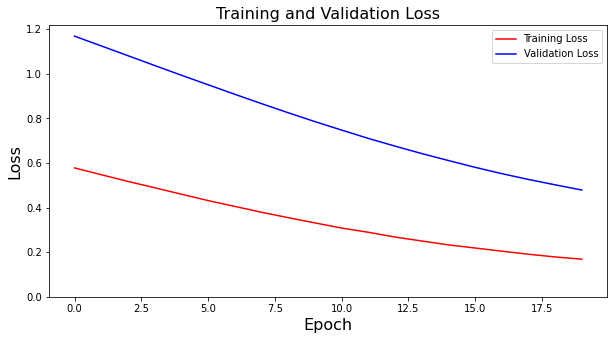

In [ ]:
RNN_model_evaluate(model1)

4/4 [==============================] - 0s 4ms/step - loss: 0.1866
Test Loss: 18.66


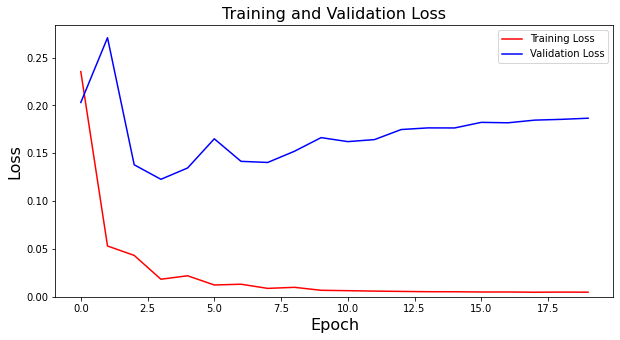

In [ ]:
RNN_model_evaluate(DEEPRNN)

In [ ]:
def show_prediction(model, dataframe, X_train, X_test, y_train, y_test, lookback=1, plot=True):
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  train_predict = scaler_train.inverse_transform(train_predict)
  test_predict = scaler_test.inverse_transform(test_predict) 
  y_train = scaler_train.inverse_transform(y_train)
  y_test = scaler_test.inverse_transform(y_test)
  RMSE_train = np.sqrt(mean_squared_error(y_train, train_predict))
  RMSE_test = np.sqrt(mean_squared_error(y_test, test_predict))
  print("############### Loss ###############")
  print("RMSE Train: ", RMSE_train, "\nRMSE Test: ", RMSE_test)

  train_prediction_df = dataframe[lookback:position]
  train_prediction_df["Predicted"] = train_predict
  print("############### Train Predictoion Head ###############")
  print(train_prediction_df.head())

  test_prediction_df = dataframe[position+lookback:]
  test_prediction_df["Predicted"] = test_predict
  print("############### Test Predictoion Head ###############")
  print(test_prediction_df.head())

  if plot:
    plt.figure(figsize=(14,5))
    plt.plot(dataframe, label="Real Number of Passengers")
    plt.plot(train_prediction_df["Predicted"], color="blue", label="Train Predicted Number of Passengers")
    plt.plot(test_prediction_df["Predicted"], color="red", label="Test Predicted Number of Passengers")
    plt.title("Number of Passengers Prediction")
    plt.xlabel("Time")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 19ms/step
############### Loss ###############
RMSE Train:  161.40004416481634 
RMSE Test:  53.9730104269427
############### Train Predictoion Head ###############
            Passengers   Predicted
Month                             
1949-02-01         118  234.033554
1949-03-01         132  231.222122
1949-04-01         129  224.608170
1949-05-01         121  226.031693
1949-06-01         135  229.811157
############### Test Predictoion Head ###############
            Passengers   Predicted
Month                             
1959-02-01         342  359.356140
1959-03-01         406  368.018158
1959-04-01         396  335.638947
1959-05-01         420  340.848053


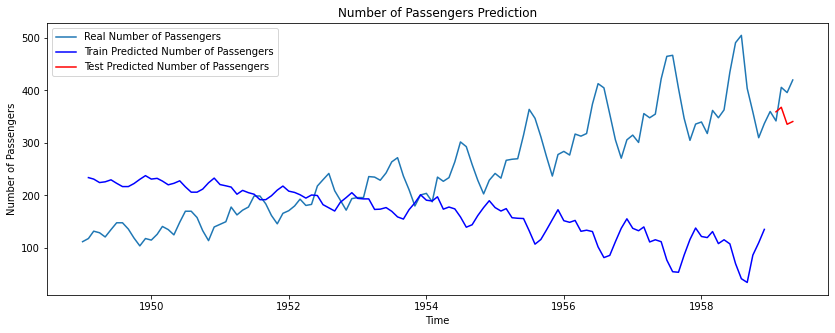

In [ ]:
show_prediction(model1, df, X_train, X_test, y_train, y_test)

1/1 [==============================] - 0s 20ms/step
############### Loss ###############
RMSE Train:  27.646009106518008 
RMSE Test:  33.69585365879684
############### Train Predictoion Head ###############
            Passengers   Predicted
Month                             
1949-02-01         118  125.696732
1949-03-01         132  125.696732
1949-04-01         129  135.300583
1949-05-01         121  132.655273
1949-06-01         135  126.767822
############### Test Predictoion Head ###############
            Passengers   Predicted
Month                             
1959-02-01         342  360.088287
1959-03-01         406  346.220337
1959-04-01         396  403.122345
1959-05-01         420  395.707611


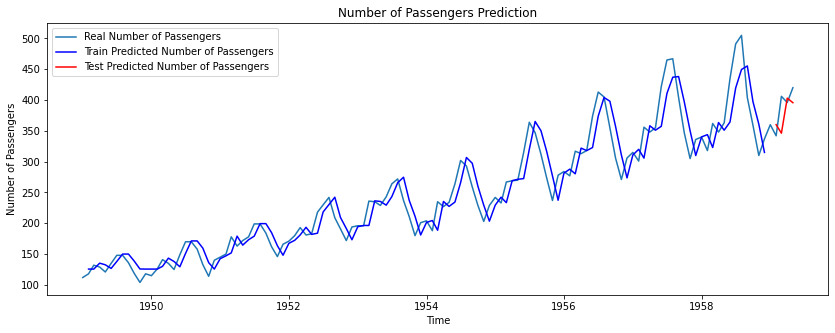

In [ ]:
show_prediction(DEEPRNN, df, X_train, X_test, y_train, y_test)

In [1]:
from tensorflow.keras.datasets import imdb
import tensorflow as tf

from numpy import array
max_features = 10000
maxlen = 500
batch_size = 32

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train =tf.keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.utils.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
SRNN=tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(1,input_shape=[None, 1])])
SRNN.compile(optimizer='adam', loss='mean_squared_error')
SRNN.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
782/782 [==============================] - 241s 301ms/step - loss: 0.4665
Epoch 2/10
782/782 [==============================] - 223s 286ms/step - loss: 0.4176
Epoch 3/10
782/782 [==============================] - 245s 314ms/step - loss: 0.4224
Epoch 4/10
782/782 [==============================] - 225s 287ms/step - loss: 0.4213
Epoch 5/10
782/782 [==============================] - 223s 285ms/step - loss: 0.4010
Epoch 6/10
782/782 [==============================] - 221s 283ms/step - loss: 0.3768
Epoch 7/10
782/782 [==============================] - 223s 285ms/step - loss: 0.3861
Epoch 8/10
782/782 [==============================] - 226s 289ms/step - loss: 0.3723
Epoch 9/10
782/782 [==============================] - 223s 286ms/step - loss: 0.3692
Epoch 10/10
782/782 [==============================] - 223s 285ms/step - loss: 0.3773


In [ ]:
SRNN.evaluate(x_test, y_test)

782/782 [==============================] - 32s 40ms/step - loss: 0.4049


0.4049086272716522

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

DEEPRNN2 = tf.keras.models.Sequential()
DEEPRNN2.add(SimpleRNN(20,input_shape=[None, 1],activation='relu', return_sequences=True))
DEEPRNN2.add(SimpleRNN(10, return_sequences=True))
DEEPRNN2.add(SimpleRNN(1))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
DEEPRNN2.compile(loss="mse", optimizer=optimizer)
history = DEEPRNN2.fit(x_train, y_train, epochs=5,validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 65s 82ms/step - loss: 0.6354
Epoch 2/10
782/782 [==============================] - 66s 85ms/step - loss: 0.4299
Epoch 3/10
782/782 [==============================] - 66s 85ms/step - loss: 0.4274
Epoch 4/10
782/782 [==============================] - 63s 81ms/step - loss: 0.4218
Epoch 5/10
782/782 [==============================] - 64s 81ms/step - loss: 0.4323
Epoch 6/10
782/782 [==============================] - 64s 82ms/step - loss: 0.4115
Epoch 7/10
782/782 [==============================] - 66s 84ms/step - loss: 0.4126
Epoch 8/10
782/782 [==============================] - 65s 83ms/step - loss: 0.4141
Epoch 9/10
782/782 [==============================] - 64s 82ms/step - loss: 0.4100
Epoch 10/10
782/782 [==============================] - 65s 83ms/step - loss: 0.4086


In [ ]:
predicted_sentiment_deep= scaler.inverse_transform(DEEPRNN2.predict(x_test))

782/782 [==============================] - 17s 22ms/step


In [ ]:
predicted_sentiment_deep

array([[505.     , 504.7383 , 503.08572],
       [505.     , 505.     , 505.     ],
       [505.     , 504.97992, 504.71576],
       ...,
       [505.     , 505.     , 505.     ],
       [505.     , 501.82974, 493.93515],
       [505.     , 505.     , 505.     ]], dtype=float32)